<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Михаил Каменев 

## <center> Индивидуальный проект по анализу данных </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from statsmodels.stats.weightstats import *

from sklearn.linear_model import RidgeCV, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBClassifier
from hyperopt import fmin,tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.model_selection import learning_curve, validation_curve
%matplotlib inline

###  Часть 1. Описание набора данных и признаков

Датасет содержит информацию о 53940 бриллиантах. По некоторым характеристикам (об этом позже) будем предсказывать стоимость. Данные можно скачать <a href='https://www.kaggle.com/shivam2503/diamonds/data'>здесь</a>.

С точки зрения бизнеса, ценность задачи понятна - по характеристикам бриллианта предсказать, сколько долларов за него можно получить. От бизнеса я далёк, поэтому интерес чисто спортивный: разобраться, какие характеристики и как влияют на стоимость этих камешков =)

<b>Признаки</b>
- carat - вес бриллианта в каратах, вещественный
- cut - качество огранки, категориальный. Принимает пять возможных значений: Fair, Good, Very Good, Premium, Ideal
- color - "цвет" бриллианта. Категориальный признак, принимает значения J,I,H,G,F,E,D (от худшего (J) к лучшему (D))
- clarity - чистота бриллианта. Категориальный признак, принимает значения I1 (худший), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (лучший)
- x,y,z - три признака, характеризущие размеры бриллианта, вещественные
- depth - признак, который высчитывается на основе трех предыдущих по формуле 2 * z / (x + y), вещественный
- table - отношение ширины верхней грани бриллианты к его максимальной ширине, в процентах


<b>Целевой признак</b>: price - стоимость бриллианта в долларах



###  Часть 2. Первичный анализ признаков

In [2]:
#загружаем dataset
diamonds_df = pd.read_csv('../../data/diamonds.csv')
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamonds_df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Видно, что масштабы признаков отличаются. В дальнейшем нужно будет применить StandartScaler

In [4]:
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Unnamed: 0    53940 non-null int64
carat         53940 non-null float64
cut           53940 non-null object
color         53940 non-null object
clarity       53940 non-null object
depth         53940 non-null float64
table         53940 non-null float64
price         53940 non-null int64
x             53940 non-null float64
y             53940 non-null float64
z             53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


В данных отсутствуют пропуски. Итого, имеется 6 вещественных, 1 целочисленный (unnamed: 0 не считаем) и 3 категориальных признака.

### Анализ целочисленных и вещественных признаков

In [5]:
real_features = ['carat', 'depth', 'table', 'x', 'y', 'z','price']

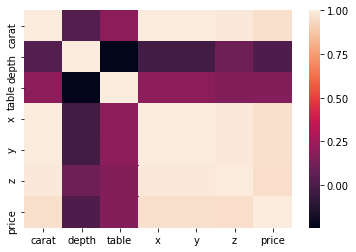

In [6]:
# Изучим корреляцию вещественных признаков и целевой переменной
sns.heatmap(diamonds_df[real_features].corr(method='spearman'));

Признаки carat, x,y,z имеют большую корреляцию, как между собой, так и с целевой переменной, что не удивительно. При этом, корреляция целевой переменной и признаков depth, table почти отсутствует

#### Анализ категориальных признаков

In [7]:
cat_features = ['cut','color','clarity']


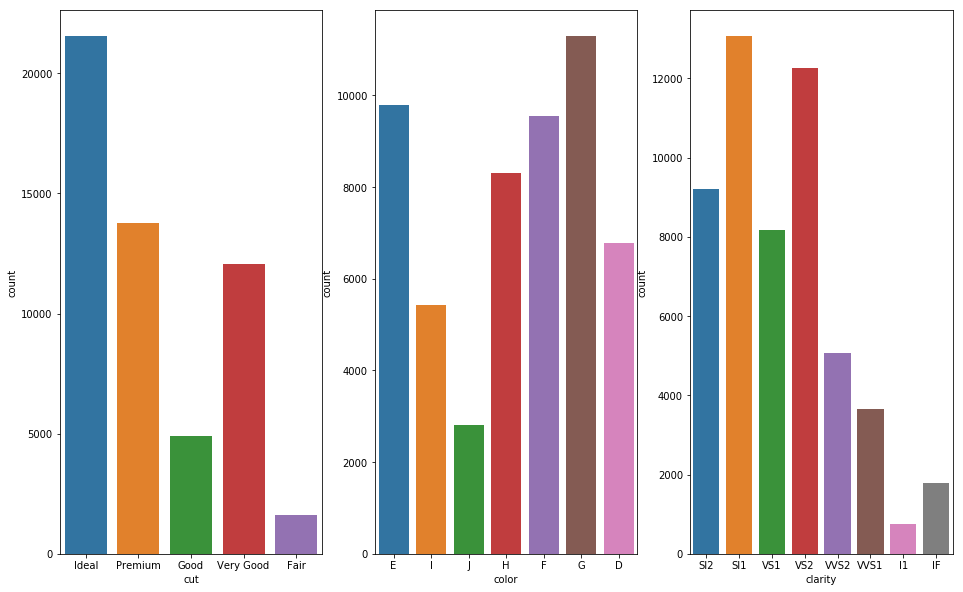

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(cat_features):
    sns.countplot(diamonds_df[feature], ax=axes[idx % 3], label=feature)

Реальные значения категориальных признаков не отличаются от тех, что заявлены в описании. Кроме того, видно, что уникальных значений не много, так что One Hot encoding должен отлично сработать. 

#### Анализ целевого признака

/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


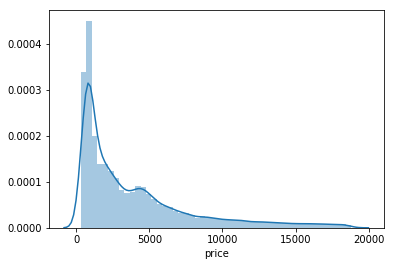

In [9]:
sns.distplot(diamonds_df['price'])

Распределение имеет тяжелый правый хвост. Применим логарифмирование.

/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


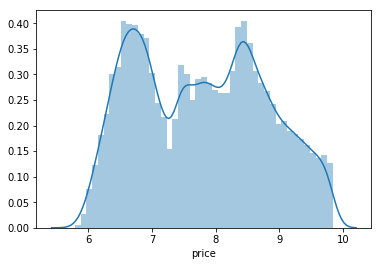

In [10]:
sns.distplot(diamonds_df['price'].map(np.log1p))

Помогло это не сильно: получилось бимодальное распределение. Зато хвост исчез =) Для наглядности, построим QQ график

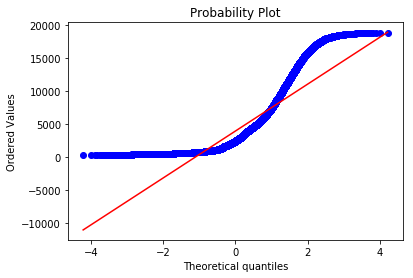

In [11]:
stats.probplot(diamonds_df['price'], dist="norm", plot=plt);

#### Выводы
- Вещественные признаки (carat, depth, table, x, y, z) масштабируем
- К категориальным признакам ('cut','color','clarity') применяем one hot encoding
- Целевую переменную логарифмируем

###  Часть 3. Первичный визуальный анализ признаков

#### Анализ целочисленных и вещественных признаков

/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


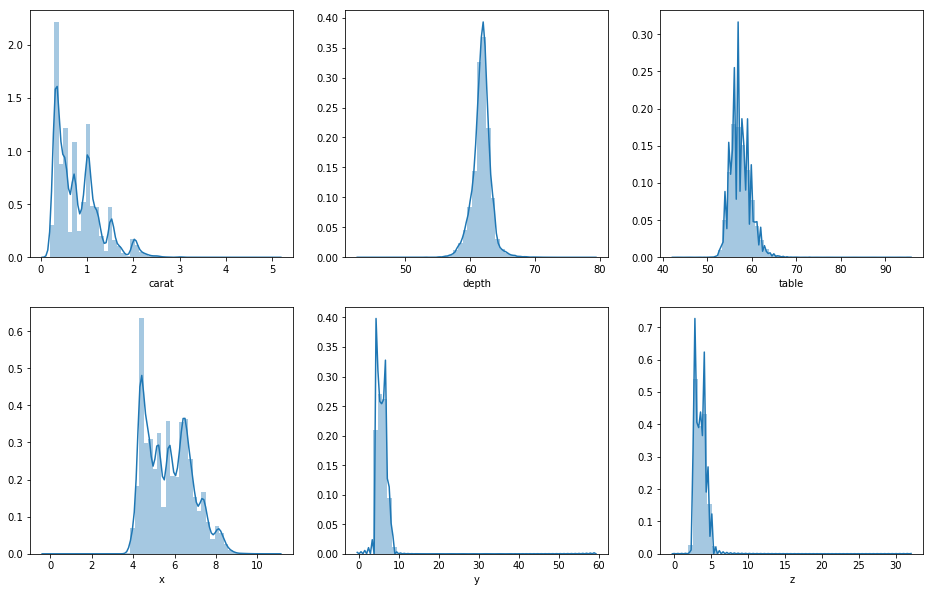

In [12]:
# Начнем с построения гистограмм вещественных признаков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(real_features[:-1]): #price рисовать не будем
    sns.distplot(diamonds_df[feature], ax=axes[idx // 3, idx % 3], label=feature)

Распределение признаков depth, table, y, z отдаленно, но напоминает колокол. У depth хвосты тяжеловаты для нормального распределения; carat и table скорее бимодальные. Кроме того, у них тяжелые правые хвосты, так что np.log1p не помешает. По графикам выше не видно выбросов. Проверим, что это действительно так, с помощью boxplot

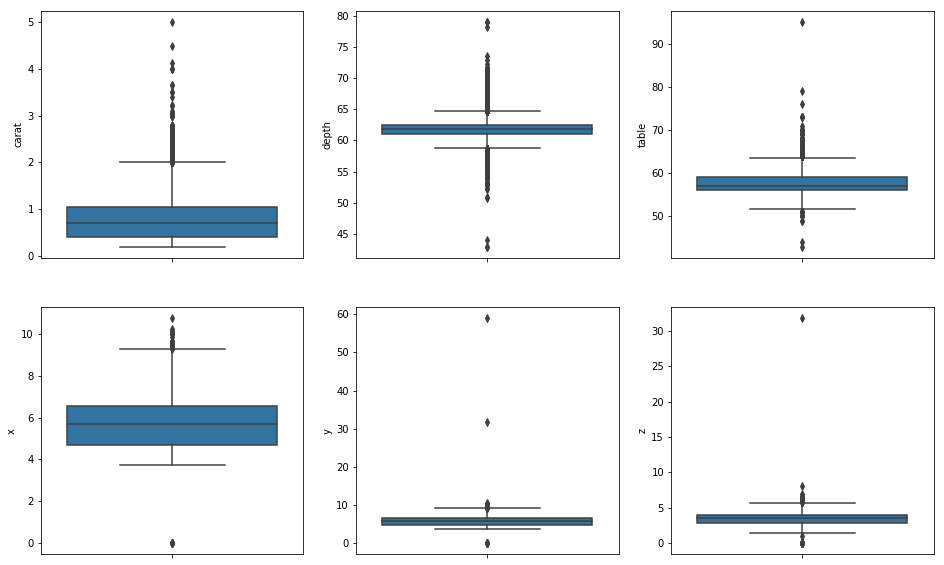

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(real_features[:-1]): #price рисовать не будем
    sns.boxplot(diamonds_df[feature], ax=axes[idx // 3, idx % 3], orient='v')

Каких-либо серьезных аномалий в рассматриваемых данных нет. На всякий случай посмотрим бриллиант с y=60, z = 32 и carat > 4. Если он стоит дорого, то за выброс его считать не будем.

In [14]:
diamonds_df[diamonds_df['y'] > 55].head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
24067,24068,2.0,Premium,H,SI2,58.9,57.0,12210,8.09,58.9,8.06


In [15]:
diamonds_df[diamonds_df['z'] > 30].head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
48410,48411,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.8


In [16]:
diamonds_df[diamonds_df['carat'] > 4].head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
25998,25999,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
25999,26000,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24
27130,27131,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
27415,27416,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
27630,27631,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72


Видно, что это просто очень дорогие камни. Посмотрим, как рассматриваемые признаки взаимосвязаны с целевой перменной

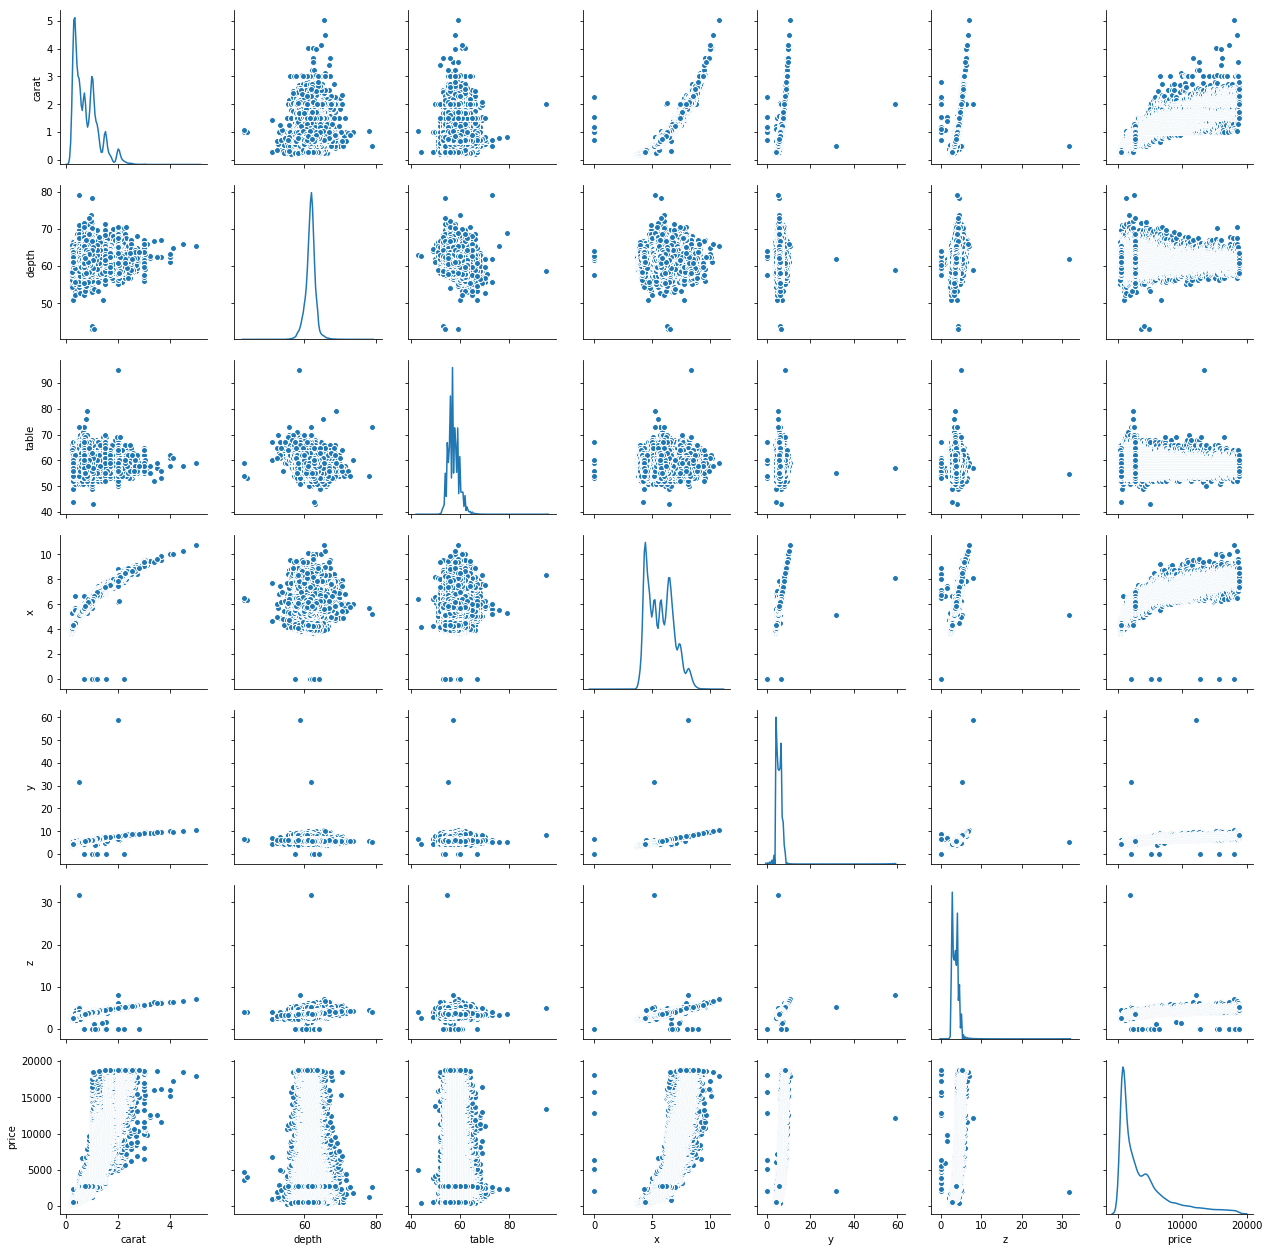

In [17]:
sns.pairplot(diamonds_df[real_features], diag_kind="kde")

- вес бриллианта показывает степенную зависимость от его размеров
- depth и table почти никак не взаимосвязаны с остальными признаками, в том числе и целевым
- x,y,z связаны между собой линейно
- цена линейно зависит от размеров
- зависимость между ценой и весом сложно назвать линейной, но монотонный тренд есть

#### Анализ категориальных признаков

Посмотрим, как целевая переменная зависит от категориальных признаков

/home/cid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  after removing the cwd from sys.path.
/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


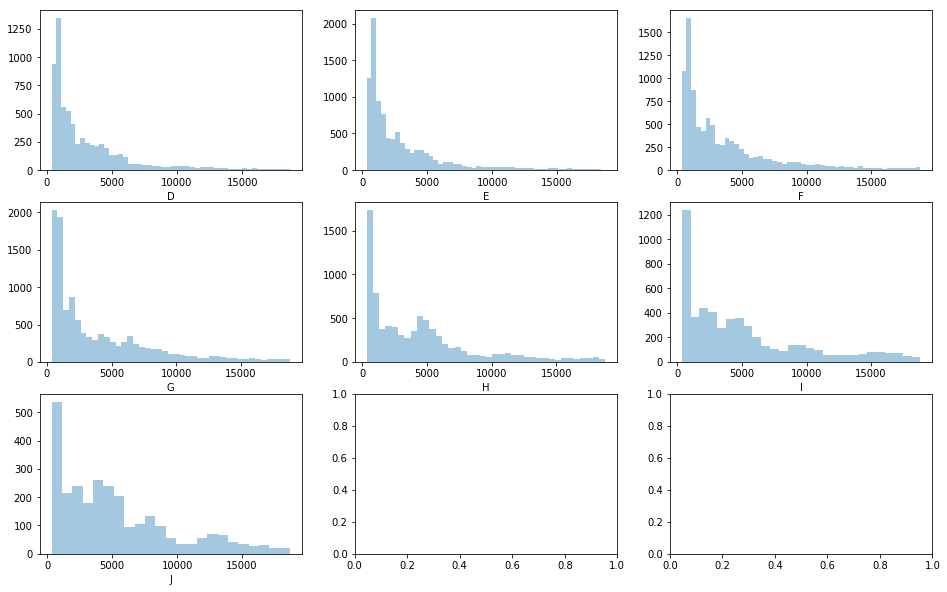

In [18]:
# цвет бриллианта
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))

for idx, (color, sub_df) in  enumerate(pd.groupby(diamonds_df, 'color')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=color)

Распределения для всех значений цветов имеют тяжелый правый хвост и не сильно отличаются друг от друга.

/home/cid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  after removing the cwd from sys.path.
/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


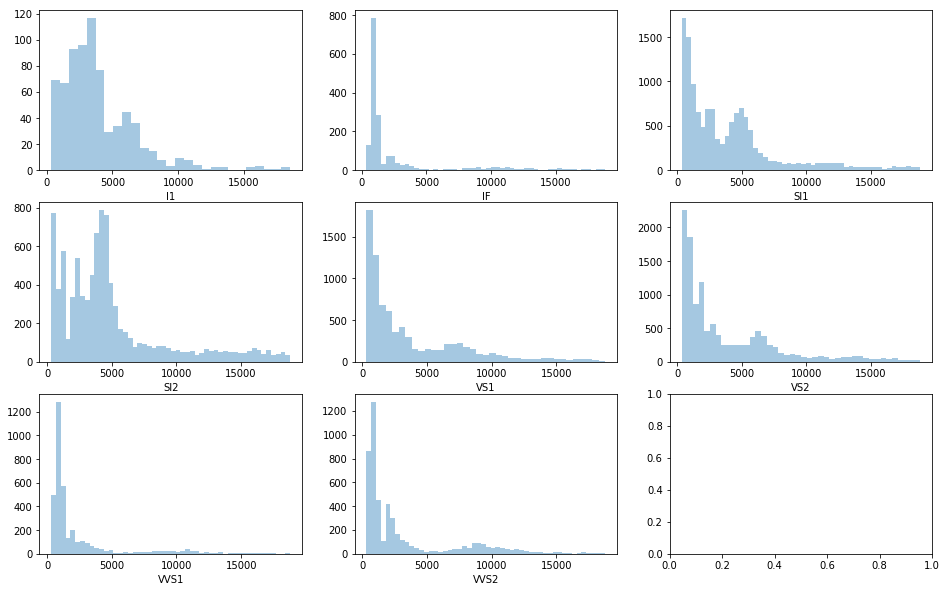

In [19]:
# чистота бриллианта
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))

for idx, (clarity, sub_df) in  enumerate(pd.groupby(diamonds_df, 'clarity')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=clarity)

Хвосты у всех тяжелые, но у SI1,SI2 присутствуют дополнительные пики в районе 5000.

/home/cid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  after removing the cwd from sys.path.
/home/cid/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


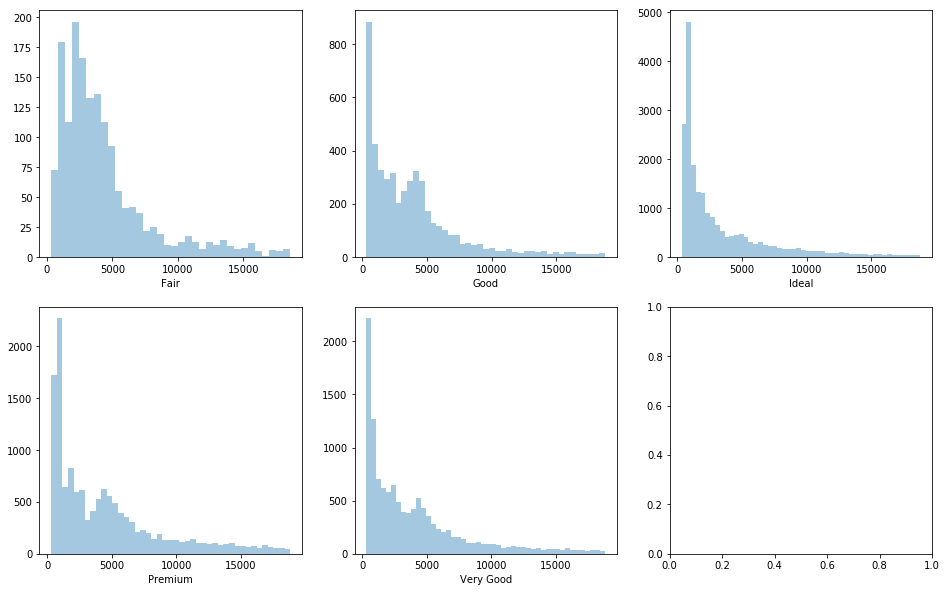

In [20]:
# качество огранки
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, (cut, sub_df) in  enumerate(pd.groupby(diamonds_df, 'cut')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=cut)

И снова пики в районе 5000 (у Good и Premium). А в целом графики похожи.

Нарисуем boxplot для каждого значения

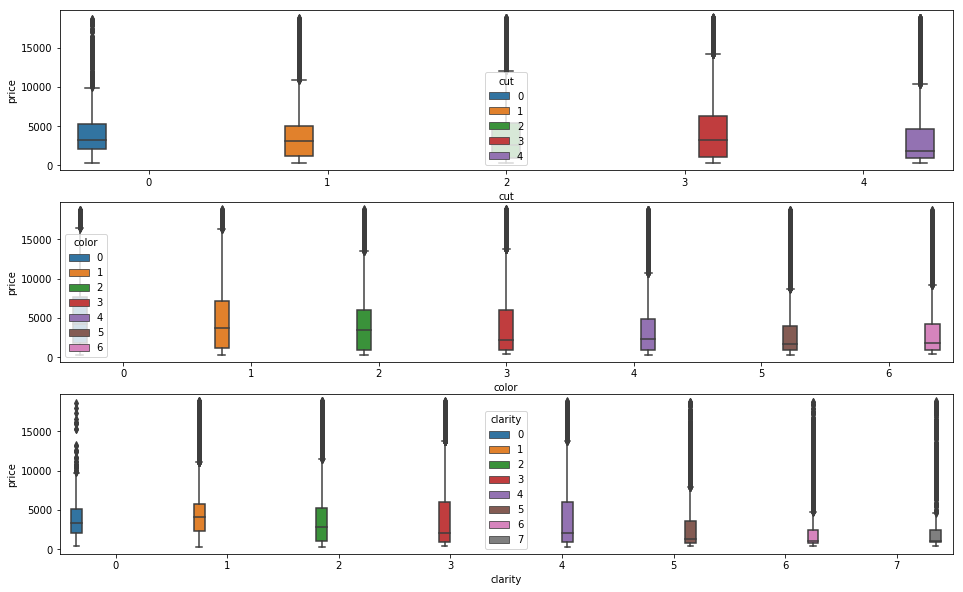

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

# Отобразим строки в числа в порядке от худшего к лучшему. Так удобнее на графике смотреть
df = diamonds_df.copy()
df['color'] = df['color'].map({'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6})
df['clarity'] = df['clarity'].map({'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7 })
df['cut'] = df['cut'].map({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})

for idx, feature in enumerate(cat_features):
    sns.boxplot(x=feature, y='price',data=df,hue=feature,  ax=axes[idx])


Тут уже интереснее. Начнем с огранки. Видно, что медиана максимальна для Very Good и Premium. Для ideal медианное значение цены гораздо меньше. Аналогичные наблюдения можно сделать для цвета и чистоты. Возможно, бриллианты с наилучшими свойствами на очень большие, и, соответсвенно, их цена ниже. Проверим это.

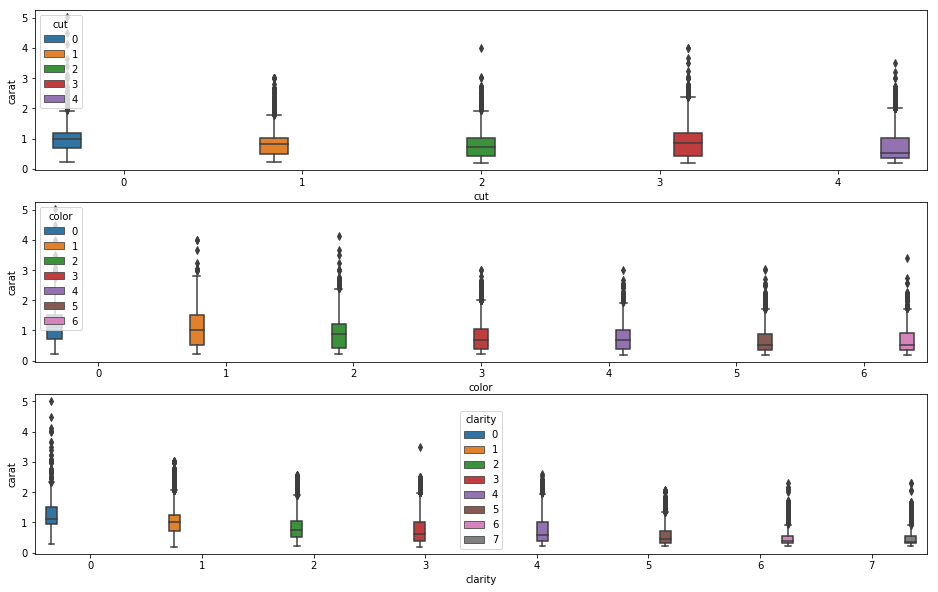

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))

for idx, feature in enumerate(cat_features):
    sns.boxplot(x=feature, y='carat',data=df,hue=feature,  ax=axes[idx])

Действительно, медианное значение веса для бриллиантов с очень хорошими характеристиками меньше, чем для бриллиантов с плохими харакетристиками. Напоследок, посмотрим сколько бриллиантов с той или иной харакеристикой присутствует в данных.

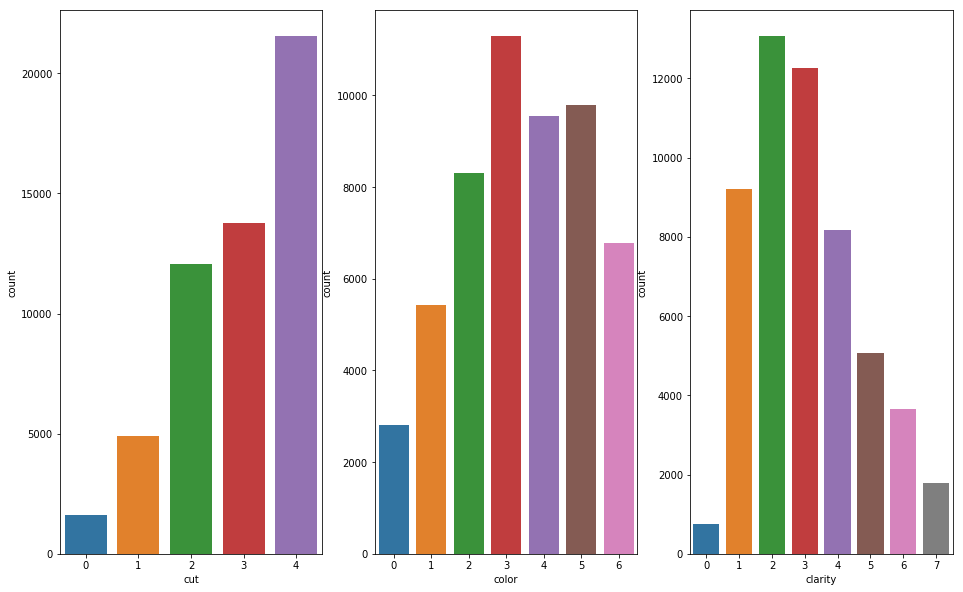

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(cat_features):
    sns.countplot(df[feature], ax=axes[idx % 3], label=feature)

Видно, что очень мало камней с плохой огранкой. Также мало камней с плохими цветовыми харакеристиками. Но и не очень много с идеальными. Распределение чистоты камня напоминает лапласовское распределение.

###  Часть 4. Закономерности, "инсайты", особенности данных

#### Основные выводы по предыдущим пунктам:
- Ключевые признаки для прогнозирования: вес и размеры бриллианта (carat, x, y, z). По графикам видно, что есть монотонная зависимость этих признаков и цены. Что логично
- Признаки depth и table почти не влияют на стоимость камня
- Исключительно по категориальным признакам сложно что-либо сказать о целевой переменной. Однако видно, что чем лучше бриллиант с точки зрения этих признаков, тем больше вероятность того, что он будет не очень большого размера
- Выбросы в данных отсутствуют
- Так как у целевой переменной очень тяжелый правый хвост, в качестве метрики будем использовать среднюю абсолютную ошибку, а не квадратичную.
- Видно, что зависимость от ключевых признаков близка к линейной. Поэтому в качестве бейзлайна будем использовать линейную регрессию.
- Более того, признаков не так уж и много, поэтому будем рассматривать также случайный лес и градиентный бустинг (тут он должен затащить =)). А случайный лес инетересен исключительно для сравнения с бустингом

###  Часть 5. Предобработка данных 

In [24]:
# Для начала, выделим выборку для тестирования
X = diamonds_df.drop(['price'], axis=1).values[:,1:] # отсекаем индекс
y = diamonds_df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=4444, shuffle=True)

In [25]:
# признаки с индексами 1,2,3 категориальные. Применим к ним ohe
label_bin = LabelBinarizer()
X_train_cut_ohe = label_bin.fit_transform(X_train[:,1])
X_test_cut_ohe = label_bin.transform(X_test[:,1])
                            
X_train_color_ohe = label_bin.fit_transform(X_train[:,2])
X_test_color_ohe = label_bin.transform(X_test[:,2])
                                                    
X_train_clarity_ohe = label_bin.fit_transform(X_train[:,3])
X_test_clarity_ohe = label_bin.transform(X_test[:,3])  

# carat, x и целевую переменную логарифмируем
log_vect = np.vectorize(np.log1p)
X_train_сarat_log = log_vect(X_train[:,0]).reshape(-1,1)
X_test_сarat_log  = log_vect(X_test[:,0]).reshape(-1,1)
X_train_x_log = log_vect(X_train[:,6]).reshape(-1,1)
X_test_x_log  = log_vect(X_test[:,6]).reshape(-1,1)
y_train_log = log_vect(y_train)
y_test_log = log_vect(y_test)

# масштабириуем вещественные признаки
scaler = StandardScaler()
X_train_real = np.hstack((X_train_сarat_log, X_train_x_log, X_train[:,[7,8,4,5]]))
X_test_real = np.hstack((X_test_сarat_log, X_test_x_log, X_test[:,[7,8,4,5]]))
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.transform(X_test_real)

# В качестве дополнительных признаков будем рассматривать полиномиальные признаки
#Данные признаки должны улучшить качество линейной модели.

X_train_additional = PolynomialFeatures().fit_transform(X_train_real)
X_test_additional = PolynomialFeatures().fit_transform(X_test_real)
X_train_additional_scaled = scaler.fit_transform(X_train_additional)
X_test_additional_scaled = scaler.transform(X_test_additional)



# Объединяем все преобразованные признаки
X_train_transformed = np.hstack((X_train_real_scaled,X_train_cut_ohe, X_train_color_ohe, X_train_clarity_ohe))
X_test_transformed = np.hstack((X_test_real_scaled,X_test_cut_ohe, X_test_color_ohe, X_test_clarity_ohe))

/home/cid/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


###  Часть 6. Создание новых признаков и описание этого процесса

Смотри предыдущий пункт

###  Часть 7. Кросс-валидация, подбор параметров

Рассмотрим сначала линейную модель. Данные разделим на 5 фолдов. С помощью RidgeCV и LassoCV будем оптимизировать силу регуляризации.

In [26]:
# функция потерь для рассматриваемой задачи. Ошибку смотрим на исходных данных
def mean_absolute_exp_error(model, X,y):
    return -mean_absolute_error(np.expm1(model.predict(X)), np.expm1(y))

In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=4444)
alphas = np.logspace(-5,2,100)
ridge_cv = RidgeCV(alphas=alphas, scoring=mean_absolute_exp_error, cv=cv)
lasso_cv = LassoCV(alphas=alphas, cv=cv, random_state=4444)

In [28]:
ridge_cv.fit(X_train_transformed, y_train_log)
lasso_cv.fit(X_train_transformed, y_train_log)
print('Optimized alpha: Ridge = %f, Lasso = %f' % (ridge_cv.alpha_, lasso_cv.alpha_))
score_ridge = mean_absolute_error(y_test, np.expm1(ridge_cv.predict(X_test_transformed)))
score_lasso = mean_absolute_error(y_test, np.expm1(lasso_cv.predict(X_test_transformed)))
print('Ridge regression score = %f' % score_ridge)
print('Lasso regression score = %f' % score_lasso)

Optimized alpha: Ridge = 0.000010, Lasso = 0.000221
Ridge regression score = 588.854813
Lasso regression score = 589.599115


Оба метода показали схожий результат. Что будет, если мы добавим новые признаки?

In [29]:
X_train_transformed_add = np.hstack((X_train_transformed, X_train_additional_scaled))
X_test_transformed_add = np.hstack((X_test_transformed, X_test_additional_scaled))
ridge_cv.fit(X_train_transformed_add, y_train_log)
lasso_cv.fit(X_train_transformed_add, y_train_log)
print('Optimized alpha: Ridge = %f, Lasso = %f' % (ridge_cv.alpha_, lasso_cv.alpha_))
score_ridge = mean_absolute_error(y_test, np.expm1(ridge_cv.predict(X_test_transformed_add)))
score_lasso = mean_absolute_error(y_test, np.expm1(lasso_cv.predict(X_test_transformed_add)))
print('Ridge regression score = %f' % score_ridge)
print('Lasso regression score = %f' % score_lasso)

/home/cid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Optimized alpha: Ridge = 52.140083, Lasso = 0.000135
Ridge regression score = 385.308688
Lasso regression score = 387.274454


/home/cid/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Ошибка значительно уменьшилась. Построим кривые валидации и обучения

CPU times: user 2.81 s, sys: 632 ms, total: 3.44 s
Wall time: 1.72 s


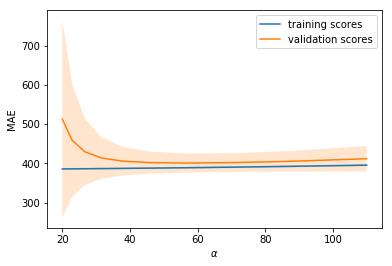

In [30]:
%%time
# код из статьи на хабре


def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

model = Ridge(random_state=4444) 
alphas = np.logspace(1,2,10) + 10 # Если коэффициент регуляризации мал, то значения получаются заоблочными
val_train, val_test = validation_curve(model, X_train_transformed_add, y_train_log,'alpha', alphas, cv=cv,scoring=mean_absolute_exp_error)
plot_with_err(alphas, -val_train, label='training scores')
plot_with_err(alphas, -val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('MAE')
plt.legend();

Судя по кривым валидации, модель недообучилась: ошибки лежат близко друг к другу. 

In [31]:
# код из статьи на хабре
    
def plot_learning_curve(model, X,y):
    train_sizes = np.linspace(0.05, 1, 20)
      
    N_train, val_train, val_test = learning_curve(model,X, y, train_sizes=train_sizes, cv=5,scoring=mean_absolute_exp_error, random_state=4444)
    plot_with_err(N_train, -val_train, label='training scores')
    plot_with_err(N_train, -val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('MAE')
    plt.legend()


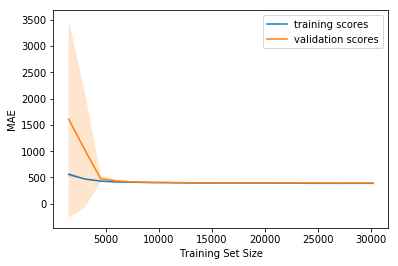

In [32]:
model = Ridge(alpha=52.140083,random_state=4444)
plot_learning_curve(model, X_train_transformed_add, y_train_log)

Кривые лежат близко друг к другу почти с самого начала. Вывод: наблюдений у нас достаточно, нужно двигаться в сторону усложнения модели

#### Случайный лес

Случайный лес должен хорошо работать "из коробки". Поэтому будем оптимизировать только число деревьев.


CPU times: user 22min 56s, sys: 7.6 s, total: 23min 3s
Wall time: 23min 3s


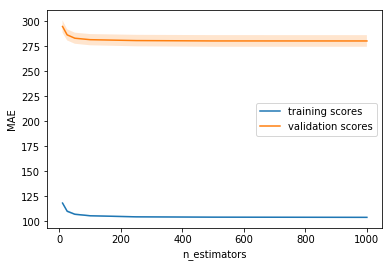

In [33]:
%%time
model = RandomForestRegressor(n_estimators=100, random_state=4444)
n_estimators = [10,25,50,100,250,500,1000]
val_train, val_test = validation_curve(model, X_train_transformed, y_train_log,'n_estimators', n_estimators, cv=cv,scoring=mean_absolute_exp_error)
    
plot_with_err(n_estimators, -val_train, label='training scores')
plot_with_err(n_estimators, -val_test, label='validation scores')
plt.xlabel('n_estimators'); plt.ylabel('MAE')
plt.legend();

Видно, что начиная с 200 деревьев качество практически не изменяется. Поэтому в качестве еще одной модели будем рассматривать случайный лес именно с таким количеством деревьев.

In [34]:
forest_model = RandomForestRegressor(n_estimators=200, random_state=4444)
forest_model.fit(X_train_transformed, y_train_log)
forest_prediction = np.expm1(forest_model.predict(X_test_transformed))
score = mean_absolute_error(y_test, forest_prediction)
print('Random forest score: %f' % score)

Random forest score: 275.090469


In [35]:
# посмотрим на важность признаков
np.argsort(forest_model.feature_importances_)

array([ 6,  7,  9, 10,  8, 13, 25, 12, 14, 19, 24,  5,  4, 11, 22,  3, 15,
       23, 16, 17, 18, 20, 21,  1,  0,  2])

Первые четыре столбца обучающей выборки соответствуют признакам carat, x,y,z. Как и предполагалось в начале, 3 из 4 этих признаков имеют наибольшую важность для модели

CPU times: user 12min 11s, sys: 3.19 s, total: 12min 14s
Wall time: 12min 14s


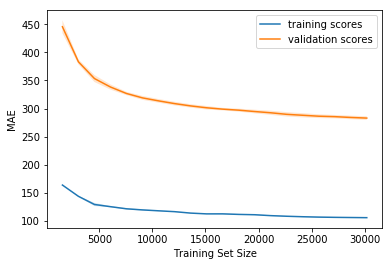

In [37]:
%%time
# Построим, также, кривую обучения
plot_learning_curve(model, X_train_transformed, y_train_log)

График выходит на полку, так что больше данных нам не нужно

#### boosting. А что boosting?

In [38]:
X_train_boosting, X_valid_boosting, y_train_boosting, y_valid_boosting = train_test_split(
    X_train_transformed, y_train_log, test_size=0.3, random_state=4444)

In [39]:
def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train_boosting, label=y_train_boosting)
    dvalid = xgb.DMatrix(X_valid_boosting, label=y_valid_boosting)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid).reshape((X_valid_boosting.shape[0], 1))
    score = mean_absolute_error(np.expm1(y_valid_boosting), np.expm1(predictions))
   # score = mean_absolute_error(y_valid_boosting, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             'num_round': 200,
             'learning_rate': hp.quniform('eta', 0.05, 0.5, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'mae',
             'objective': 'reg:linear',
             'nthread' : 4,
             'silent' : 1,
             'seed': 4444
             }
    
    best = fmin(score, space, algo=tpe.suggest,trials=trials, max_evals=100)
    return best

In [40]:
%%time
# Оптимизация параметров
trials = Trials()
best_params = optimize(trials)

Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'mae', 'gamma': 0.67, 'learning_rate': 0.34500000000000003, 'max_depth': 9.0, 'min_child_weight': 6.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.6000000000000001}
	Score 315.660619606406


Training with params:
{'colsample_bytree': 0.4, 'eval_metric': 'mae', 'gamma': 0.97, 'learning_rate': 0.18, 'max_depth': 12.0, 'min_child_weight': 6.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.8}
	Score 321.8745715577723


Training with params:
{'colsample_bytree': 0.45, 'eval_metric': 'mae', 'gamma': 0.56, 'learning_rate': 0.385, 'max_depth': 6.0, 'min_child_weight': 6.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.55}
	Score 332.6647748920204


Training with params:
{'colsample_bytree': 0.55, 'eval_metric': 'mae', 'gamma': 0.7000000000000001, 'learning_rate': 0.38

	Score 311.60422416460716


Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'mae', 'gamma': 0.5, 'learning_rate': 0.19, 'max_depth': 10.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 1.0}
	Score 299.6931288956249


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'mae', 'gamma': 0.59, 'learning_rate': 0.15, 'max_depth': 10.0, 'min_child_weight': 10.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 1.0}
	Score 299.7860018546972


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'mae', 'gamma': 0.59, 'learning_rate': 0.05, 'max_depth': 11.0, 'min_child_weight': 8.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 1.0}
	Score 305.92404384128116


Training with params:
{'colsample_bytree': 0.6000000000000001, 'eval_metric':

	Score 312.1475925903536


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'mae', 'gamma': 0.71, 'learning_rate': 0.18, 'max_depth': 10.0, 'min_child_weight': 1.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 1.0}
	Score 309.2039397719216


Training with params:
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'mae', 'gamma': 0.5, 'learning_rate': 0.275, 'max_depth': 12.0, 'min_child_weight': 10.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.8}
	Score 310.3743696320529


Training with params:
{'colsample_bytree': 0.65, 'eval_metric': 'mae', 'gamma': 0.67, 'learning_rate': 0.295, 'max_depth': 14.0, 'min_child_weight': 7.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.5}
	Score 321.21913049988825


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'mae', 'gamma': 0.58, 'learning_rate': 0

	Score 308.8622460553875


Training with params:
{'colsample_bytree': 0.75, 'eval_metric': 'mae', 'gamma': 0.73, 'learning_rate': 0.165, 'max_depth': 12.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.9500000000000001}
	Score 307.01260656690863


Training with params:
{'colsample_bytree': 0.65, 'eval_metric': 'mae', 'gamma': 0.51, 'learning_rate': 0.155, 'max_depth': 6.0, 'min_child_weight': 10.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 0.9}
	Score 305.69526951730586


Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'mae', 'gamma': 0.85, 'learning_rate': 0.1, 'max_depth': 9.0, 'min_child_weight': 10.0, 'nthread': 4, 'num_round': 200, 'objective': 'reg:linear', 'seed': 4444, 'silent': 1, 'subsample': 1.0}
	Score 313.8238869737097


Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'mae', 'gamma': 0.54, 'learning_rate': 0.

In [42]:
best_params

{'colsample_bytree': 0.65,
 'eta': 0.145,
 'gamma': 0.55,
 'max_depth': 10.0,
 'min_child_weight': 4.0,
 'subsample': 1.0}

In [45]:
params = {
             'num_round': 200,
             'colsample_bytree': 0.65,
             'eta': 0.145,
             'gamma': 0.55,
             'max_depth': 10,
             'min_child_weight': 4.0,
             'subsample': 1.0,
             'eval_metric': 'mae',
             'objective': 'reg:linear',
             'nthread' : 4,
             'silent' : 1,
             'seed': 4444}

In [46]:
dtrain = xgb.DMatrix(X_train_transformed, label=y_train_log)
dvalid = xgb.DMatrix(X_test_transformed, label=y_test_log)
boosting_model = xgb.train(params, dtrain, params['num_round'])
predictions = boosting_model.predict(dvalid).reshape((X_test_transformed.shape[0], 1))
score = mean_absolute_error(y_test, np.expm1(predictions))
print('Boosting score: %f' % score)

Boosting score: 287.465612


###  Часть 8. Построение кривых валидации и обучения 

В большом количестве в предыдущем пункте

###  Часть 9. Прогноз для тестовой или отложенной выборки

В большом количестве в части 7

###  Часть 10. Оценка модели с описанием выбранной метрики

Приведем результаты различных моделей на тестовой выборке.
Как уже оговаривалось ранее, в качестве метрики используем MAE

In [47]:
pure_ridge = Ridge(random_state=4444, alpha=0.00001) # гребневая регрессия на исходных данных
pure_ridge.fit(X_train_transformed, y_train_log)
pure_ridge_score = mean_absolute_error(y_test, np.expm1(pure_ridge.predict(X_test_transformed)))
print('Ridge regression score: %f' % pure_ridge_score)
poly_ridge = Ridge(random_state=4444, alpha=52.140083) # гребневая регрессия с полиномиальными признаками
poly_ridge.fit(X_train_transformed_add, y_train_log)
poly_ridge_score = mean_absolute_error(y_test, np.expm1(poly_ridge.predict(X_test_transformed_add)))
print('Ridge regression score with poly features: %f' % poly_ridge_score)
forest_score = mean_absolute_error(y_test, np.expm1(forest_model.predict(X_test_transformed)))
print('Random forest score: %f' % forest_score)
boosting_score = mean_absolute_error(y_test, np.expm1(boosting_model.predict(dvalid)))
print('XGBoost score: %f' % boosting_score)

Ridge regression score: 588.854813
Ridge regression score with poly features: 385.308688
Random forest score: 275.090469
XGBoost score: 287.465612


Результаты близки к тем, что получались на кросс-валидации. Так что всё хорошо =)

### Часть 11. Выводы 

В данном проекте рассматривались достаточно "простые" данные, поэтому основной упор был сделан на применение различных моделей для их анализа. С одной стороны, случайный лес без какой-либо настройки гиперпараметров показал лучший результат. С другой стороны, если потратить больше времени на оптимизацию градиентного бустинга, возможно, он сможет показать результат лучше, чем у случайного леса. Стоит, также, отметить линейную модель: после добавления полиномиальных признаков она показала очень неплохой результат (если сравнивать с моделью без дополнительных признаков =)). Зато сложность гораздо меньше. Если вдруг кому-то по жизни придется оценивать бриллианты, можете смело использовать предложенную модель случайного леса. В среднем будете терять по 275 $ с одного камушка :p

Спасибо за внимание!